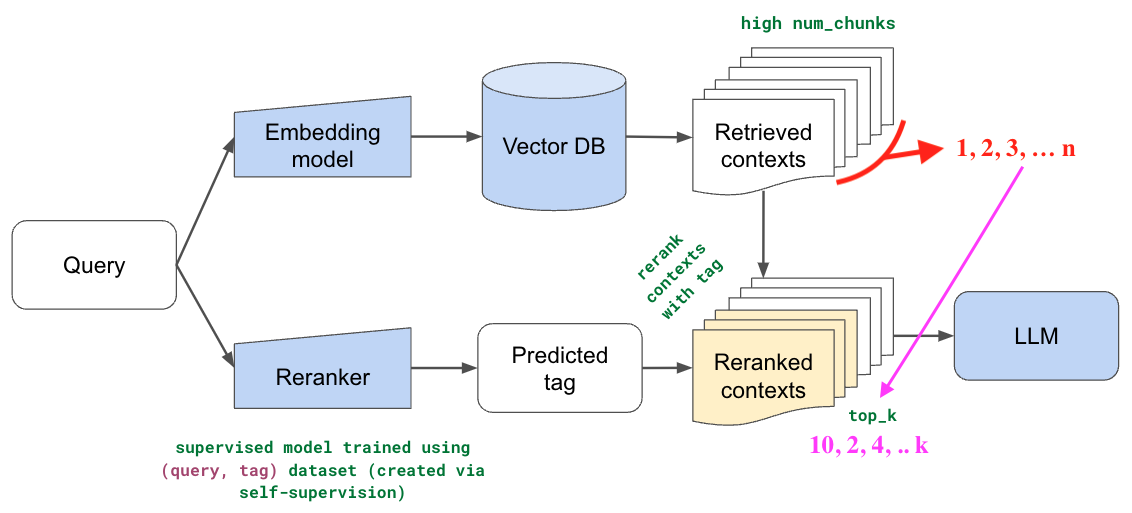

# Problem Statement:


In a typical RAG pipeline, LLM Context window is limited so for a hypothetical 10000 pages document, we need to chunk the document. For any incoming user query, we need to fetch `Top-N` related chunks and because neither our Embedding are 100% accurate nor search algo is perfect, it could give us unrelated results too. This is a flaw in RAG pipeline. How can you deal with it? If you fetch Top-1 and the context is different then it's a sure bad answer. On the other hand, if you fetch more chunks and pass to LLM, it'll get confused and with higher number, it'll go out of context.

# What's the remedy?

Out of all the methods available, Re-ranking is the simplest. Idea is pretty simple.


1. You assume that Embedding + Search algo are not 100% precise so you use Recall to your advantage and get similar high `N` (say 25) number of related chunks from corpus.

2. Second step is to use a powerful model to increase the Precision. You re-rank above `N` queries again so that you can change the relative ordering and now select Top `K` queries (say 3) to pass as a context where `K` < `N` thus increasing the Precision.


# Why can't you use the bigger model in the first place?
Would your search results be better if you were searching in 100 vs 100000 documents? Yes, so no matter how big of a model you use, you'll always have some irrelevent results because of the huge domain.


Smaller model with efficient searching algo does the work of searching in a bigger domain to get more number of elements while the larger model is precise and because it just works on `K`, there is a bit more overhead but improved relevancy.


### Installing dependencies

In [5]:
# NOTE: If there is an import error, restart and run the notebook again

!pip install -U lancedb transformers datasets FlagEmbedding unstructured langchain peft -qq

### Importing libraries

In [6]:
# All document present here https://github.com/FlagOpen/FlagEmbedding/tree/master

from FlagEmbedding import (
    LLMEmbedder,
    FlagReranker,
)
import os
import lancedb
import re
import pandas as pd
import random

from datasets import load_dataset

import torch
import gc

import lance
from lancedb.embeddings import with_embeddings


task = "qa"  # Encode for a specific task (qa, icl, chat, lrlm, tool, convsearch)

# Load model (automatically use GPUs)
embed_model = LLMEmbedder("BAAI/llm-embedder", use_fp16=False)

# use_fp16 speeds up computation with a slight performance degradation
reranker_model = FlagReranker("BAAI/bge-reranker-base", use_fp16=True)

# For basic splitting
# basic_text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64,) # 512 is the default Embedding model max_len

# For Advanced Usage: https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/split_by_token
# embedder_tokenizer = AutoTokenizer.from_pretrained("BAAI/llm-embedder") # Advanced Tokenizer Splitter Strategy
# advanced_text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder_tokenizer, chunk_size=512, chunk_overlap=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

# Load `Chunks` of data from [BeIR Dataset](https://huggingface.co/datasets/BeIR/scidocs)

Note: This is a dataset built specially for retrieval tasks to see how good your search is working

In [7]:
queries = load_dataset("BeIR/scidocs", "queries")["queries"].to_pandas()
docs = (
    load_dataset("BeIR/scidocs", "corpus")["corpus"]
    .to_pandas()
    .dropna(subset="text")
    .sample(10000)
)  # just random samples for faster embed demo
docs.sample(3)

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating corpus split:   0%|          | 0/25657 [00:00<?, ? examples/s]

,_id,title,text
8884,bd151b04739107e09c646933f2abd3ecb3e976c9,On the Spectral Bias of Neural Networks,Neural networks are known to be a class of hig...
25052,5097d63ea8ed7ac4e829e1847a35fac5b3ca4cd1,Optimal design methodology for LLC resonant co...,Although LLC resonant converter can achieve wi...
19949,a083ba4f23dd2e5229f6009253e28ef4f81759e7,Extracting Social Structures from Conversation...,"Online Social Networks (e.g., Twitter, Faceboo..."


# Get embedding using [`LLM embedder`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/llm_embedder) and create Database using [`LanceDB`](https://github.com/lancedb/lancedb)

In [8]:
def embed_documents(batch):
    """
    Function to embed the whole text data
    """
    return embed_model.encode_keys(batch, task=task)  # Encode data or 'keys'


db = lancedb.connect("./db")  # Connect Local DB
if "doc_embed" in db.table_names():
    table = db.open_table("doc_embed")  # Open Table
else:
    # Use the train text chunk data to save embed in the DB
    data = with_embeddings(
        embed_documents, docs, column="text", show_progress=True, batch_size=128
    )
    table = db.create_table("doc_embed", data=data)  # create Table

<ipython-input-8-1b4e9d2d0cd7>:13: DeprecationWarning: Function with_embeddings is deprecated and will be removed in a future version
  data = with_embeddings(
/usr/local/lib/python3.10/dist-packages/ratelimiter.py:127: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  __aexit__ = asyncio.coroutine(__exit__)


  0%|          | 0/79 [00:00<?, ?it/s]

# Search from a random Text

In [9]:
def search(query, top_k=10):
    """
    Search a query from the table
    """
    query_vector = embed_model.encode_queries(
        query, task=task
    )  # Encode the QUERY (it is done differently than the 'key')
    search_results = table.search(query_vector).limit(top_k)
    return search_results


query = random.choice(queries["text"])
print("QUERY:-> ", query)

# get top_k search results
search_results = (
    search("what is mitochondria?", top_k=10)
    .to_pandas()
    .dropna(subset="text")
    .reset_index(drop=True)
)

search_results

QUERY:->  MODEL AS A DESCRIPTIVE TOOL IN EVALUATING A VIRTUAL LEARNING ENVIRONMENT


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,_id,title,text,vector,_distance
0,2c13b73ce6123966a9f8c82b8f26d9e3fbc312b7,The biology of cancer: metabolic reprogramming...,"Cell proliferation requires nutrients, energy,...","[-0.006399014, -0.0021278195, -0.0141027495, -...",0.347475
1,8f5d905a63dc11f3895949c05c73a660d73aa4b7,Timing to Perfection: The Biology of Central a...,"The mammalian circadian system, which is compr...","[0.00504799, 0.044294223, -0.011634435, -0.014...",0.360853
2,587ad4f178340d7def5437fe5ba0ab0041a53c4b,Ocular symptom detection using smartphones,"It is often said that ""the eyes are the window...","[0.012119509, 0.045184057, 0.007815617, -0.019...",0.361442
3,cbf4040cb14a019ff3556fad5c455e99737f169f,Answering Schrödinger's question: A free-energ...,The free-energy principle (FEP) is a formal mo...,"[-0.010098261, 0.013940676, 0.0005950298, 0.01...",0.366217
4,e0534bfb477c5a82e98d0cb386ae3eb31d349c91,Cellular and molecular mechanisms of hepatocel...,Hepatocellular carcinoma (HCC) is the most com...,"[0.039844867, 0.015836274, -0.009343517, -0.02...",0.366525
5,8dcc86121219fdb9f813d43b35c632811da18b73,A framework for consciousness,Here we summarize our present approach to the ...,"[0.018000692, 0.016094409, -0.015705932, -0.01...",0.375436
6,65f415c6d88aca139867702fc64aa179781b8e65,PID: the Pathway Interaction Database,"The Pathway Interaction Database (PID, http://...","[-0.007852315, 0.014019211, -0.026789218, -0.0...",0.378376
7,55877f7c574b4686c98e70b96971722c1593ba9f,Calorie restriction extends Saccharomyces cere...,Calorie restriction (CR) extends lifespan in a...,"[-0.028346285, 0.023852367, -0.02474031, 0.006...",0.381004
8,205966b977df580587ca61e71c3015dff9044687,Organoids as an in vitro model of human develo...,The in vitro organoid model is a major technol...,"[0.028107636, -0.01863825, -0.032238886, 0.008...",0.382393
9,f8be08195b1a7e9e45028eee4844ea2482170a3e,Gut microbiota functions: metabolism of nutrie...,The diverse microbial community that inhabits ...,"[0.027819183, 0.033666402, -0.024391493, 0.002...",0.382530


# Rerank Search Results using Reranker from [`BGE Reranker`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/reranker)

Pass all the results to a stronger model to give them the similarity ranking

In [10]:
def rerank(query, search_results):
    search_results["old_similarity_rank"] = search_results.index + 1  # Old ranks

    torch.cuda.empty_cache()
    gc.collect()

    search_results["new_scores"] = reranker_model.compute_score(
        [[query, chunk] for chunk in search_results["text"]]
    )  # Re compute ranks
    return search_results.sort_values(by="new_scores", ascending=False).reset_index(
        drop=True
    )


print("QUERY:-> ", query)

rerank(query, search_results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QUERY:->  MODEL AS A DESCRIPTIVE TOOL IN EVALUATING A VIRTUAL LEARNING ENVIRONMENT


,_id,title,text,vector,_distance,old_similarity_rank,new_scores
0,cbf4040cb14a019ff3556fad5c455e99737f169f,Answering Schrödinger's question: A free-energ...,The free-energy principle (FEP) is a formal mo...,"[-0.010098261, 0.013940676, 0.0005950298, 0.01...",0.366217,4,-6.007812
1,8dcc86121219fdb9f813d43b35c632811da18b73,A framework for consciousness,Here we summarize our present approach to the ...,"[0.018000692, 0.016094409, -0.015705932, -0.01...",0.375436,6,-6.078125
2,205966b977df580587ca61e71c3015dff9044687,Organoids as an in vitro model of human develo...,The in vitro organoid model is a major technol...,"[0.028107636, -0.01863825, -0.032238886, 0.008...",0.382393,9,-6.218750
3,2c13b73ce6123966a9f8c82b8f26d9e3fbc312b7,The biology of cancer: metabolic reprogramming...,"Cell proliferation requires nutrients, energy,...","[-0.006399014, -0.0021278195, -0.0141027495, -...",0.347475,1,-6.644531
4,65f415c6d88aca139867702fc64aa179781b8e65,PID: the Pathway Interaction Database,"The Pathway Interaction Database (PID, http://...","[-0.007852315, 0.014019211, -0.026789218, -0.0...",0.378376,7,-6.718750
5,587ad4f178340d7def5437fe5ba0ab0041a53c4b,Ocular symptom detection using smartphones,"It is often said that ""the eyes are the window...","[0.012119509, 0.045184057, 0.007815617, -0.019...",0.361442,3,-6.812500
6,8f5d905a63dc11f3895949c05c73a660d73aa4b7,Timing to Perfection: The Biology of Central a...,"The mammalian circadian system, which is compr...","[0.00504799, 0.044294223, -0.011634435, -0.014...",0.360853,2,-7.652344
7,55877f7c574b4686c98e70b96971722c1593ba9f,Calorie restriction extends Saccharomyces cere...,Calorie restriction (CR) extends lifespan in a...,"[-0.028346285, 0.023852367, -0.02474031, 0.006...",0.381004,8,-7.695312
8,f8be08195b1a7e9e45028eee4844ea2482170a3e,Gut microbiota functions: metabolism of nutrie...,The diverse microbial community that inhabits ...,"[0.027819183, 0.033666402, -0.024391493, 0.002...",0.382530,10,-8.257812
9,e0534bfb477c5a82e98d0cb386ae3eb31d349c91,Cellular and molecular mechanisms of hepatocel...,Hepatocellular carcinoma (HCC) is the most com...,"[0.039844867, 0.015836274, -0.009343517, -0.02...",0.366525,5,-10.195312
